In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
import matplotlib.dates as mdates

In [94]:
import re

with open('wmo121000iso.txt', 'r', encoding='ISO-8859-2') as file:
    lines = file.readlines()[1:8000]

data = [re.split(r'\s+', line.strip()) for line in lines]

columns = [
    'N', 'M', 'D', 'H', 'DBT', 'RH', 'HR', 'WS', 'WD',
    'ITH', 'IDH', 'ISH', 'TSKY',
    'N_0', 'N_30', 'NE_30', 'E_30', 'SE_30', 'S_30', 'SW_30', 'W_30', 'NW_30',
    'N_45', 'NE_45', 'E_45', 'SE_45', 'S_45', 'SW_45', 'W_45', 'NW_45',
    'N_60', 'NE_60', 'E_60', 'SE_60', 'S_60', 'SW_60', 'W_60', 'NW_60',
    'N_90', 'NE_90', 'E_90', 'SE_90', 'S_90', 'SW_90', 'W_90', 'NW_90'
]

df = pd.DataFrame(data, columns=columns)
df = df.drop(index=0)
df = df.apply(pd.to_numeric, errors='coerce')

def calculate_date(row):
    total_hours = row['N'] - 1
    remaining_hours = total_hours % 8760

    days_passed = remaining_hours // 24
    hour = row['H']

    month_days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

    month = 0
    while days_passed >= month_days[month]:
        days_passed -= month_days[month]
        month += 1

    day = days_passed + 1
    return pd.Timestamp(year=1993, month=int(month) + 1, day=int(day), hour=int(hour))

df['date'] = df.apply(calculate_date, axis=1)

df.set_index('date', inplace=True)

In [95]:
df.head(5)

,N,M,D,H,DBT,RH,HR,WS,WD,ITH,...,W_60,NW_60,N_90,NE_90,E_90,SE_90,S_90,SW_90,W_90,NW_90
date,,,,,,,,,,,,,,,,,,,,,
1993-01-01 00:00:00,1,1,1,0,0.9,74,2.991,5.0,31,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993-01-01 01:00:00,2,1,1,1,0.9,74,2.988,4.0,30,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993-01-01 02:00:00,3,1,1,2,0.9,75,3.026,4.0,30,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993-01-01 03:00:00,4,1,1,3,0.9,76,3.063,4.0,29,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993-01-01 04:00:00,5,1,1,4,1.2,75,3.087,3.0,29,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [96]:
selected_columns = ['DBT', 'RH', 'WS']
df_selected = df[selected_columns]

In [97]:
def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

for column in selected_columns:
    print(f'Testing {column} for stationarity:')
    test_stationarity(df_selected[column])

df_selected_diff = df_selected.diff().dropna()

model = VAR(df_selected_diff)
model_fitted = model.fit(maxlags=15, ic='aic')

print(model_fitted.summary())

n_hours = 12

last_values = df_selected_diff.values[-model_fitted.k_ar:]

forecast_diff = model_fitted.forecast(last_values, steps=n_hours)

forecast_index = pd.date_range(start=df_selected.index[-1] + pd.Timedelta(hours=1), periods=n_hours, freq='h')
forecast_df = pd.DataFrame(forecast_diff, index=forecast_index, columns=df_selected.columns)

forecast_level = forecast_df.cumsum() + df_selected.iloc[-1]

print(forecast_level)

Testing DBT for stationarity:
ADF Statistic: -3.258865028583211
p-value: 0.01682036876421232
Critical Values:
	1%: -3.4311714754806224
	5%: -2.861903033070527
	10%: -2.5669632378194773
Testing RH for stationarity:
ADF Statistic: -11.508226754213249
p-value: 4.3232246078133386e-21
Critical Values:
	1%: -3.4311716819221716
	5%: -2.8619031242902278
	10%: -2.5669632863767267
Testing WS for stationarity:
ADF Statistic: -11.04134606885124
p-value: 5.356228579854498e-20
Critical Values:
	1%: -3.4311716819221716
	5%: -2.8619031242902278
	10%: -2.5669632863767267


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 22, Oct, 2024
Time:                     20:48:17
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -2.52496
Nobs:                     7982.00    HQIC:                  -2.60438
Log likelihood:          -23280.8    FPE:                  0.0709541
AIC:                     -2.64572    Det(Omega_mle):       0.0697414
--------------------------------------------------------------------
Results for equation DBT
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const           0.000476         0.003835            0.124           0.901
L1.DBT          0.770145         0.014645           52.586           0.000
L1.RH           0.000255         0.002456            0.104           0.917
L1.WS      

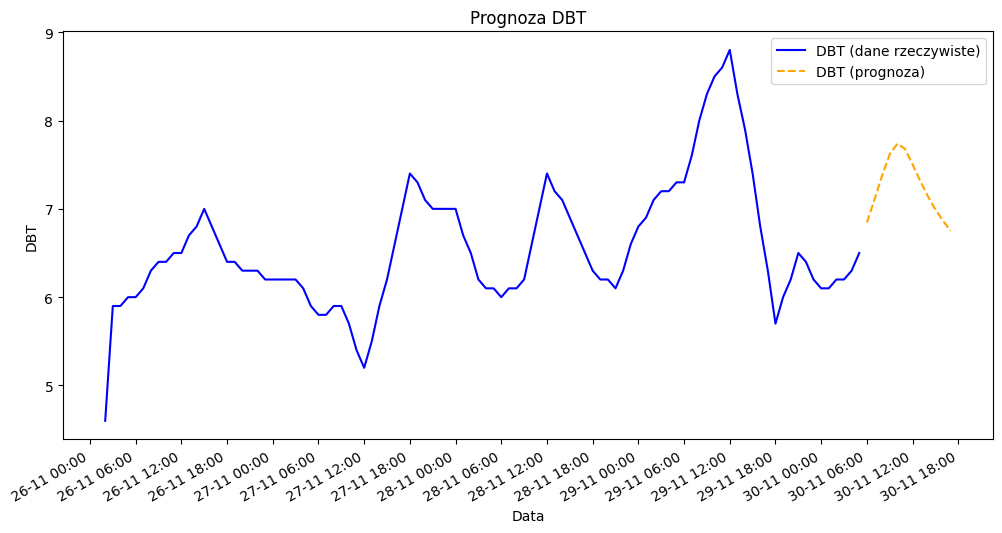

In [98]:
plt.figure(figsize=(12, 6))
plt.plot(df_selected.index[-100:], df_selected['DBT'].values[-100:], label='DBT (dane rzeczywiste)', color='blue')
plt.plot(forecast_level.index, forecast_level['DBT'], label='DBT (prognoza)', color='orange', linestyle='--')

plt.title('Prognoza DBT')
plt.xlabel('Data')
plt.ylabel('DBT')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=6))
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

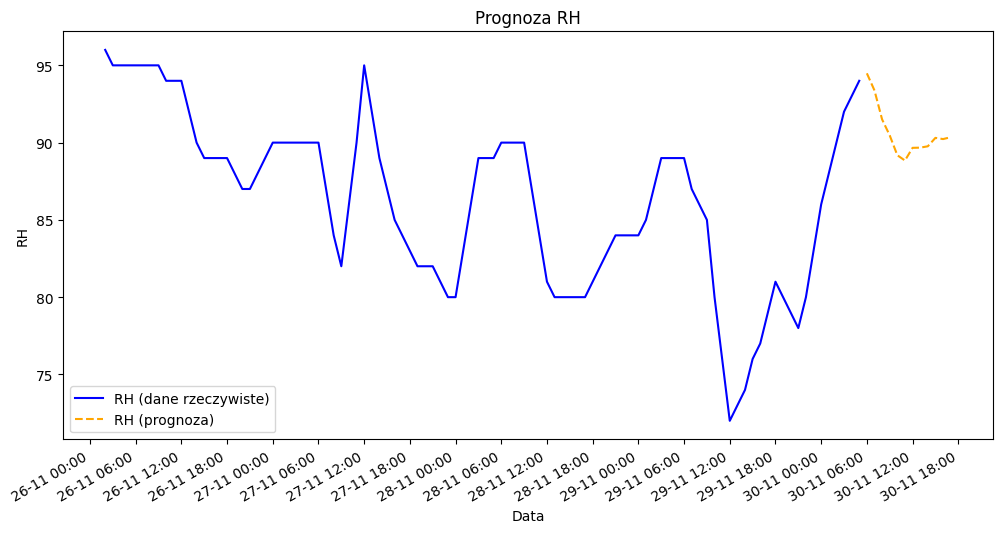

In [99]:
plt.figure(figsize=(12, 6))
plt.plot(df_selected.index[-100:], df_selected['RH'].values[-100:], label='RH (dane rzeczywiste)', color='blue')
plt.plot(forecast_level.index, forecast_level['RH'], label='RH (prognoza)', color='orange', linestyle='--')

plt.title('Prognoza RH')
plt.xlabel('Data')
plt.ylabel('RH')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=6))
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

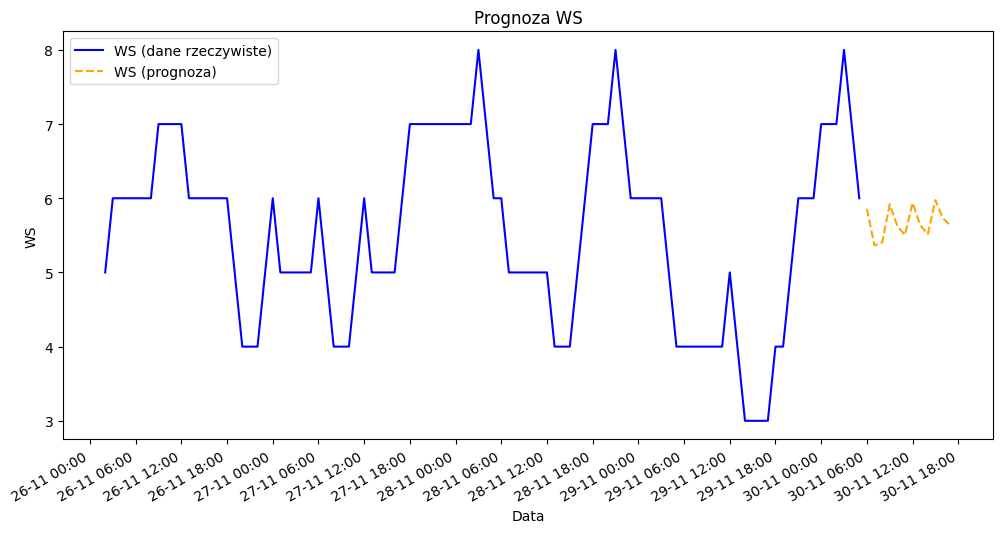

In [100]:
plt.figure(figsize=(12, 6))
plt.plot(df_selected.index[-100:], df_selected['WS'].values[-100:], label='WS (dane rzeczywiste)', color='blue')
plt.plot(forecast_level.index, forecast_level['WS'], label='WS (prognoza)', color='orange', linestyle='--')

plt.title('Prognoza WS')
plt.xlabel('Data')
plt.ylabel('WS')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=6))
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()